In [2]:
!pip install colour
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import library
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
import os,re,glob,cv2
import PIL
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from tensorflow import keras
import argparse
from sklearn.cluster import KMeans
import cv2 as cv
import colour
import utils
import math
import timeit
import warnings
import colorsys
from collections import OrderedDict
import dlib
import imutils
import matplotlib
import matplotlib.image as mpimg

In [4]:
# data preprocessing
class ImageTransform() :
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [9]:
# data load & split
springwarm_dir = '/content/drive/MyDrive/cheek/spring/'
summercool_dir = '/content/drive/MyDrive/cheek/summercolor/'
autumnwarm_dir = '/content/drive/MyDrive/cheek/autumn/'
wintercool_dir = '/content/drive/MyDrive/cheek/wintercolor/'

file_names1 = os.listdir(springwarm_dir)
file_names2 = os.listdir(summercool_dir)
file_names3 = os.listdir(autumnwarm_dir)
file_names4 = os.listdir(wintercool_dir)

springwarm_images_filepath = sorted([os.path.join(springwarm_dir, f) for f in os.listdir(springwarm_dir)])
summercool_images_filepath = sorted([os.path.join(summercool_dir, f) for f in os.listdir(summercool_dir)])
autumnwarm_images_filepath = sorted([os.path.join(autumnwarm_dir, f) for f in os.listdir(autumnwarm_dir)])
wintercool_images_filepath = sorted([os.path.join(wintercool_dir, f) for f in os.listdir(wintercool_dir)])

images_filepath = [*springwarm_images_filepath, *summercool_images_filepath, *autumnwarm_images_filepath, *wintercool_images_filepath]
correct_images_filepath = [i for i in images_filepath if cv2.imread(i) is not None]

random.seed(3)
random.shuffle(correct_images_filepath)
train_image_filepaths = correct_images_filepath[:5500]
val_image_filepaths = correct_images_filepath[5500:-20]
test_image_filepaths = correct_images_filepath[-20:]

print(len(train_image_filepaths), len(val_image_filepaths), len(test_image_filepaths))

5500 923 20


In [10]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

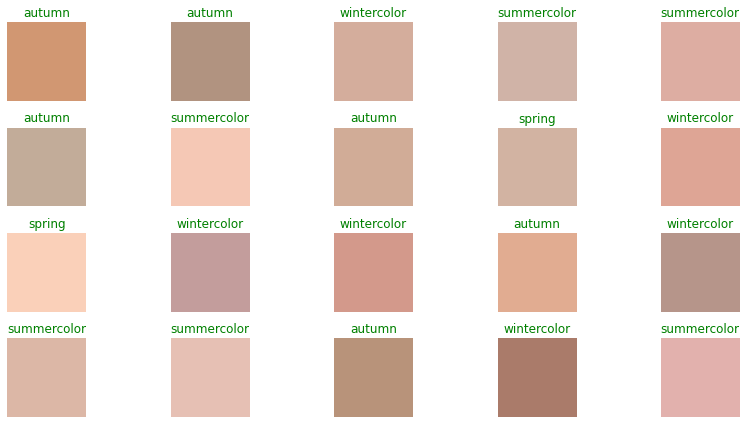

In [11]:
display_image_grid(test_image_filepaths)

In [15]:
# define custom dataset
class WarmCoolDataset(Dataset) :
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        return len(self.file_list)
    
    def __getitem__(self, idx) :
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'spring' :
            label = 3
        elif label == 'summer' :
            label = 2
        elif label == 'autumn' :
            label = 1
        elif label == 'winter' :
            label = 0
            
        return img_transformed, label

In [16]:
# define variables, 얘를 수정하면 성능이 좋아지려나...?

size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [17]:
train_dataset = WarmCoolDataset(train_image_filepaths, transform=ImageTransform(size, mean, std),
                               phase='train')
val_dataset = WarmCoolDataset(val_image_filepaths, transform=ImageTransform(size, mean, std),
                             phase='val')
test_dataset = WarmCoolDataset(val_image_filepaths, transform=ImageTransform(size, mean, std),
                            phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [18]:
# load dataset to memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([2, 1, 2, 3, 1, 3, 1, 3, 1, 3, 2, 2, 0, 3, 1, 1, 1, 0, 3, 1, 2, 0, 0, 1,
        1, 1, 2, 3, 3, 2, 2, 1])


In [19]:
# define model network
class AlexNet(nn.Module) :
    def __init__(self) -> None :
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 4),)
        
    def forward(self, x :torch.Tensor) -> torch.Tensor :
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [20]:
# create model
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
# optimizer, loss function
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [23]:
# check model Network 
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [24]:
# define training function
def train_model(model, dataloader_dict, criterion, optimizer, n_epochs) :
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(n_epochs) :
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val'] :
            if phase == 'train' :
                model.train()
                
            else :
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]) :
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()
                        
                epoch_loss += loss.item() * inputs.size(0)
                epoch_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:0f}')

    return model

In [25]:
n_epochs = 15
model = train_model(model, dataloader_dict, criterion, optimizer, n_epochs)

Epoch 1/15
--------------------


100%|██████████| 172/172 [10:02<00:00,  3.50s/it]


train Loss : 1.3862 Acc : 0.3133


100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


val Loss : 1.3852 Acc : 0.2969
Epoch 2/15
--------------------


100%|██████████| 172/172 [09:59<00:00,  3.49s/it]


train Loss : 1.3827 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


val Loss : 1.3822 Acc : 0.2969
Epoch 3/15
--------------------


100%|██████████| 172/172 [10:03<00:00,  3.51s/it]


train Loss : 1.3795 Acc : 0.3167


100%|██████████| 29/29 [00:39<00:00,  1.36s/it]


val Loss : 1.3794 Acc : 0.2969
Epoch 4/15
--------------------


100%|██████████| 172/172 [10:01<00:00,  3.50s/it]


train Loss : 1.3764 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.30s/it]


val Loss : 1.3767 Acc : 0.2969
Epoch 5/15
--------------------


100%|██████████| 172/172 [10:11<00:00,  3.56s/it]


train Loss : 1.3736 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


val Loss : 1.3742 Acc : 0.2969
Epoch 6/15
--------------------


100%|██████████| 172/172 [10:12<00:00,  3.56s/it]


train Loss : 1.3707 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.30s/it]


val Loss : 1.3717 Acc : 0.2969
Epoch 7/15
--------------------


100%|██████████| 172/172 [10:10<00:00,  3.55s/it]


train Loss : 1.3677 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


val Loss : 1.3691 Acc : 0.2969
Epoch 8/15
--------------------


100%|██████████| 172/172 [10:06<00:00,  3.53s/it]


train Loss : 1.3647 Acc : 0.3167


100%|██████████| 29/29 [00:38<00:00,  1.34s/it]


val Loss : 1.3660 Acc : 0.2969
Epoch 9/15
--------------------


100%|██████████| 172/172 [10:10<00:00,  3.55s/it]


train Loss : 1.3611 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.30s/it]


val Loss : 1.3624 Acc : 0.2969
Epoch 10/15
--------------------


100%|██████████| 172/172 [10:05<00:00,  3.52s/it]


train Loss : 1.3564 Acc : 0.3167


100%|██████████| 29/29 [00:41<00:00,  1.42s/it]


val Loss : 1.3575 Acc : 0.2969
Epoch 11/15
--------------------


100%|██████████| 172/172 [10:06<00:00,  3.53s/it]


train Loss : 1.3498 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


val Loss : 1.3506 Acc : 0.2969
Epoch 12/15
--------------------


100%|██████████| 172/172 [10:10<00:00,  3.55s/it]


train Loss : 1.3397 Acc : 0.3167


100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


val Loss : 1.3413 Acc : 0.2969
Epoch 13/15
--------------------


100%|██████████| 172/172 [10:05<00:00,  3.52s/it]


train Loss : 1.3289 Acc : 0.3167


100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


val Loss : 1.3336 Acc : 0.2969
Epoch 14/15
--------------------


100%|██████████| 172/172 [10:08<00:00,  3.54s/it]


train Loss : 1.3218 Acc : 0.3169


100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


val Loss : 1.3273 Acc : 0.2969
Epoch 15/15
--------------------


100%|██████████| 172/172 [10:14<00:00,  3.57s/it]


train Loss : 1.3154 Acc : 0.3256


100%|██████████| 29/29 [00:37<00:00,  1.30s/it]

val Loss : 1.3197 Acc : 0.3164
Training complete in 161m 23.116037


In [ ]:
# make prediction
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad() :
    for test_path in tqdm(test_image_filepaths) :
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 3].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0]*100-25.8)

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
        
res = pd.DataFrame({'id' : id_list,
                   'label' : pred_list})
res.to_csv('./alexnet.csv', index=False)
res.head(30)

100%|██████████| 30/30 [00:02<00:00, 12.03it/s]


,id,label
0,406,0.694065
1,143,0.001569
2,377,0.508563
3,823,0.731053
4,413,0.700985
5,449,0.354599
6,113,0.768499
7,249,0.661574
8,779,0.536697
9,232,0.917091


In [ ]:
# result visualization
class_ = classes = {3 : 'winter', 2 : 'fall', 1 : 'summer', 0 : 'spring'}

def display_image_grid(images_filepaths, pred_labels=(), cols=5) :
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths) :
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        print(label)
        
        if label > 0.75 :
            label = 3
        elif label > 0.5 :
            label = 2
        elif label > 0.24 :
            label = 1
        else :
            label = 0
            
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
        
    plt.tight_layout()
    plt.show()

0.5633877038955681
0.8413331031799309
0.2499984025955193
0.5633877038955681
0.791339707374572
0.5633877038955681
0.2499984025955193
0.7009850263595574
1.048891377449035
0.3545985937118523
0.5085633516311638
0.30993385314941335
0.9170906066894524
0.2499984025955193
0.5579338788986199
0.2499984025955193
0.6940649271011345
0.5129740953445427
0.5085633516311638
0.2840564966201775
0.30993385314941335
0.5129740953445427
0.9642587423324578
0.5085633516311638
0.35005671977996755
0.30993385314941335
0.7309482812881463
0.504125785827636
0.8856789588928216
0.4115687131881707


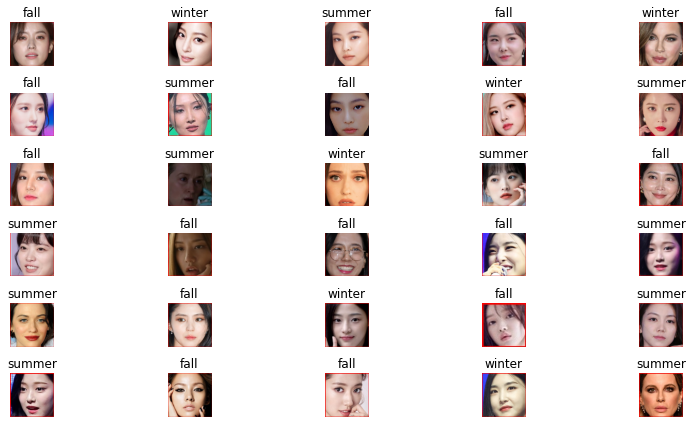

In [ ]:
display_image_grid(test_image_filepaths)